In [1]:
# Imports
import pandas as pd
import numpy as np
import os

In [2]:
# Load data

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')

In [3]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

In [4]:
from sentence_transformers import SentenceTransformer

# Specify the model name
# I downloaded in models directory three models: 
# all-MiniLM-L6-v2(Fastest but smalles), stsb-roberta-base-v2(middle), and stsb-mpnet-base-v2(Slowest, but best performance)

name = 'stsb-mpnet-base-v2'


# Download and save the model if not available
#model = SentenceTransformer(name)

#model.save('models/' + name)

# Load the model
model_enc = SentenceTransformer('models/' + name).to('cuda')

2023-08-10 09:42:55.443265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 09:42:56.288950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# # List of sentences to get embeddings for
# sentences = list(df.words_str.values)

# # Get the sentence embeddings
# sentence_embeddings = model_enc.encode(sentences)

In [6]:
# Augmentation
from random import shuffle
import nltk
from nltk.corpus import wordnet

# Download WordNet data
nltk.download('wordnet')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words]))
    shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = np.random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Original data
original_sentences = list(df.words_str.values)

# Augmented data
augmented_sentences = original_sentences.copy()
for _ in range(4): # 4 times to make the total data 5 times
    augmented_sentences += [synonym_replacement(sentence) for sentence in original_sentences]

# Use augmented sentences for embeddings
sentences = augmented_sentences
sentence_embeddings = model_enc.encode(sentences)
X = sentence_embeddings

# Original target
original_y = df.sentiment.values

# Augmented target
y_text = np.tile(original_y, 5) # Repeat 5 times


# Classification

In [8]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score


In [9]:
X = sentence_embeddings
# y_text = df.sentiment.values
le = preprocessing.LabelEncoder()
le.fit(y_text)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y =le.transform(y_text)
print(f"X: {X.shape}")
print(f"y: {y.shape} {np.unique(y)}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=None, shuffle=True)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

Original classes ['negative' 'neutral' 'positive']
Corresponding numeric classes [0 1 2]
X: (40000, 768)
y: (40000,) [0 1 2]


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassificationNN(nn.Module):
    def __init__(self, input_dim, num_classes=3, dropout_rate=0.5):
        super(ClassificationNN, self).__init__()
        
        # First set of layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Second set of layers
        self.fc3 = nn.Linear(128, 128)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        # First set of layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # Second set of layers
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        
        # Output
        x = self.fc5(x)
        return x


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)


In [13]:
# Count the number of occurrences of each class
class_counts = df['sentiment'].value_counts()

# Calculate the proportions of each class
class_proportions = class_counts / len(df)

# Calculate weights as the inverse of class proportions
weights = 1. / class_proportions

# Normalize the weights so they sum to 1
weights = weights / weights.sum()

# Print the weights
print(weights)


sentiment
neutral     0.069689
positive    0.165465
negative    0.764846
Name: count, dtype: float64


In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
learning_rate = 0.001
epochs = 500
batch_size = 32

# Initialize the model and move to the device
model_clf = ClassificationNN(X_train.shape[1]).to(device)

# weights = torch.tensor([0.764846, 0.069689, 0.165465], dtype=torch.float32).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # This criterion combines nn.LogSoftmax() and nn.NLLLoss
weight_decay_value = 1e-5  # This is a hyperparameter and can be adjusted
optimizer = torch.optim.AdamW(model_clf.parameters(), lr=learning_rate, weight_decay=weight_decay_value)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

# Helper function to compute f1_score
def compute_f1_score(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
    return f1_score(y_true, y_pred, average='macro')

# Training loop
training_losses = []
validation_losses = []
training_f1 = []
validation_f1 = []

best_f1 = float('-inf')  # start with a very low value
best_epoch = -1  # an invalid epoch number to start with

for epoch in range(epochs):
    # Set model to training mode and ensure it's on the right device
    model_clf.train().to(device)
    
    # Forward pass on training data
    train_outputs = model_clf(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Set model to evaluation mode
    model_clf.eval()
    with torch.no_grad():
        # Forward pass on validation data
        val_outputs = model_clf(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        scheduler.step(val_loss)
    
    # Store the losses for plotting
    training_losses.append(train_loss.item())
    validation_losses.append(val_loss.item())
    
    # Calculate and store the F1 score for plotting
    train_f1 = compute_f1_score(y_train_tensor, train_outputs)
    val_f1 = compute_f1_score(y_val_tensor, val_outputs)
    training_f1.append(train_f1)
    validation_f1.append(val_f1)
    
    current_val_f1 = val_f1

    # Check if the current F1 score is better than the best F1 score
    if current_val_f1 > best_f1:
        best_f1 = current_val_f1
        best_epoch = epoch
    else:
        # Stop training after a certain number of epochs without improvement
        if epoch - best_epoch > 100:
            print(f"Stopping training after {epoch} epochs. Best F1 {best_f1:.4f} achieved at epoch {best_epoch}.")
            break
    
    # Print progress
    if epoch < 100 and epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')
    elif 100 < epoch < 300 and epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')
    elif 300 < epoch < 1000 and epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')
    elif epoch > 1000 and epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')

# If the loop completed without breaking, print the best F1 score achieved
if best_epoch != epoch:
    print(f"Training completed. Best F1 {best_f1:.4f} achieved at epoch {best_epoch}.")

Epoch [1/500], Training Loss: 1.1318, Validation Loss: 1.1226, Training F1: 0.1065, Validation F1: 0.0367
Epoch [6/500], Training Loss: 1.0703, Validation Loss: 1.0497, Training F1: 0.3183, Validation F1: 0.2663
Epoch [11/500], Training Loss: 0.9025, Validation Loss: 0.8441, Training F1: 0.2665, Validation F1: 0.2663
Epoch [16/500], Training Loss: 0.8358, Validation Loss: 0.7593, Training F1: 0.2671, Validation F1: 0.2663
Epoch [21/500], Training Loss: 0.8029, Validation Loss: 0.7646, Training F1: 0.3202, Validation F1: 0.2663
Epoch [26/500], Training Loss: 0.7674, Validation Loss: 0.7141, Training F1: 0.3077, Validation F1: 0.2663
Epoch [31/500], Training Loss: 0.7361, Validation Loss: 0.6812, Training F1: 0.2965, Validation F1: 0.2663
Epoch [36/500], Training Loss: 0.7000, Validation Loss: 0.6507, Training F1: 0.3732, Validation F1: 0.4649
Epoch [41/500], Training Loss: 0.6631, Validation Loss: 0.6050, Training F1: 0.4407, Validation F1: 0.4828
Epoch [46/500], Training Loss: 0.6384, 

Epoch [61/500], Training Loss: 0.5944, Validation Loss: 0.5512, Training F1: 0.4886, Validation F1: 0.4989
Epoch [66/500], Training Loss: 0.5805, Validation Loss: 0.5441, Training F1: 0.4923, Validation F1: 0.5016
Epoch [71/500], Training Loss: 0.5647, Validation Loss: 0.5333, Training F1: 0.5006, Validation F1: 0.5056
Epoch [76/500], Training Loss: 0.5491, Validation Loss: 0.5207, Training F1: 0.5016, Validation F1: 0.5066
Epoch [81/500], Training Loss: 0.5300, Validation Loss: 0.5087, Training F1: 0.5098, Validation F1: 0.5111
Epoch [86/500], Training Loss: 0.5101, Validation Loss: 0.4954, Training F1: 0.5164, Validation F1: 0.5157
Epoch [91/500], Training Loss: 0.4892, Validation Loss: 0.4815, Training F1: 0.5237, Validation F1: 0.5208
Epoch [96/500], Training Loss: 0.4656, Validation Loss: 0.4649, Training F1: 0.5343, Validation F1: 0.5272
Epoch [111/500], Training Loss: 0.3850, Validation Loss: 0.4095, Training F1: 0.6541, Validation F1: 0.6575
Epoch [121/500], Training Loss: 0.32

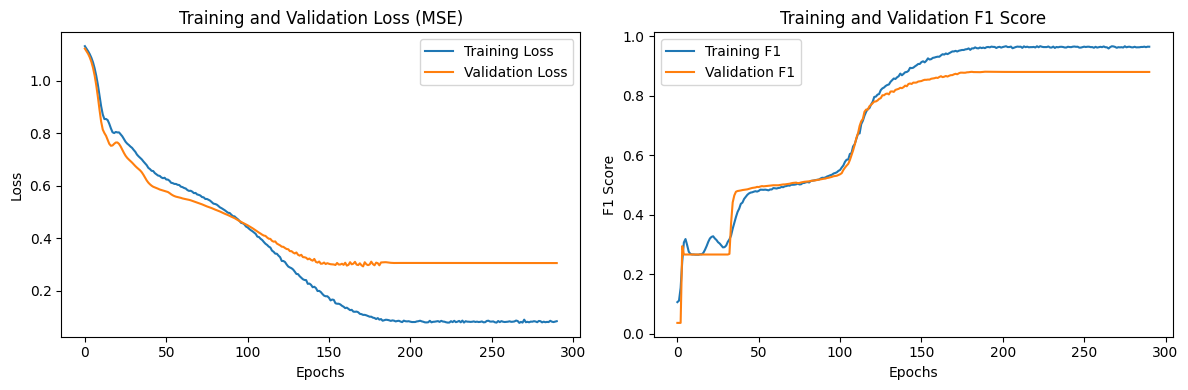

In [15]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Loss (MSE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation F1 Score
plt.subplot(1, 2, 2)
plt.plot(training_f1, label='Training F1')
plt.plot(validation_f1, label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Encode the test sentences
sentences = list(df_test.words_str.values)
X_test = model_enc.encode(sentences)

# Convert to a PyTorch tensor and move to the device
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predictions with the neural network
model_clf.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_hat_tensor = model_clf(X_test_tensor)

# Get the class predictions
y_hat = torch.argmax(y_hat_tensor, dim=1)

# Convert the tensor to a numpy array
y_hat = y_hat.cpu().numpy()

# Convert the numerical labels back to original form
y_hat = le.inverse_transform(y_hat)

# Save the results with the specified format
directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__clf_pred.npy'), y_hat)


In [17]:
# Load 20__test_1__clf_pred.npy

np.load('results/20__test_1__clf_pred.npy', allow_pickle=True).shape

(1000,)